In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from osgeo import gdal
from rasterio import plot, mask, Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from shapely.geometry import box
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# %matplotlib widget
# %matplotlib inline

In [3]:
res_vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2017_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2018_combined_res.vrt"]

In [4]:
vrt16_fn = res_vrt_path[0]    
vrt16_src = rio.open(vrt16_fn)
vrt16_r = vrt16_src.read(1, masked=True)

In [5]:
vrt17_fn = res_vrt_path[1]
vrt17_src = rio.open(vrt17_fn)
vrt17_r = vrt17_src.read(1, masked=True)

In [6]:
vrt18_fn = res_vrt_path[2]
vrt18_src = rio.open(vrt18_fn)
vrt18_r = vrt18_src.read(1, masked=True)

In [7]:
hs18_fn = "/home/jovyan/nz-landslides/1-raw-data/dem/2018_hs.vrt"
hs18_src = rio.open(hs18_fn)
hs18_r = hs18_src.read(1, masked=True)
hs18_r_extent = rio.plot.plotting_extent(hs18_src)

In [8]:
proj_crs = vrt16_src.crs

In [9]:
inventory_fn = "/home/jovyan/nz-landslides/1-raw-data/polygon/landslides_inventory.gpkg"
filt_area    = "/home/jovyan/nz-landslides/1-raw-data/polygon/filtered_area.gpkg"

In [10]:
inventory_gpd = gpd.read_file(inventory_fn)

In [11]:
filt_area_gpd = gpd.read_file(filt_area)

In [12]:
filt_area_gpd_proj = filt_area_gpd.to_crs(proj_crs)

In [13]:
inventory_gpd_proj = inventory_gpd.to_crs(proj_crs)

In [14]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
fa_hull = filt_area_gpd_proj.unary_union.convex_hull.buffer(-20)
fa_geom = gpd.GeoDataFrame(geometry=[fa_hull], crs=proj_crs)

In [15]:
vrt16_fa_ma, vrt16_fa_transform = rio.mask.mask(vrt16_src, fa_geom.geometry, **rio_mask_kwargs)
vrt16_fa_ma_extent = rio.plot.plotting_extent(vrt16_fa_ma, vrt16_fa_transform)

In [16]:
vrt17_fa_ma, vrt17_fa_transform = rio.mask.mask(vrt17_src, fa_geom.geometry, **rio_mask_kwargs)
vrt17_fa_ma_extent = rio.plot.plotting_extent(vrt17_fa_ma, vrt17_fa_transform)

In [17]:
vrt18_fa_ma, vrt18_fa_transform = rio.mask.mask(vrt18_src, fa_geom.geometry, **rio_mask_kwargs)
vrt18_fa_ma_extent = rio.plot.plotting_extent(vrt18_fa_ma, vrt18_fa_transform)

In [18]:
inventory_gpd_clipped = gpd.clip(inventory_gpd_proj, fa_geom)

In [19]:
vrt16_fa_ma.shape

(7998, 8821)

In [20]:
vrt17_fa_ma.shape

(7998, 8821)

In [21]:
vrt18_fa_ma.shape

(7998, 8821)

In [22]:
diff = vrt18_fa_ma - vrt16_fa_ma
diff

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

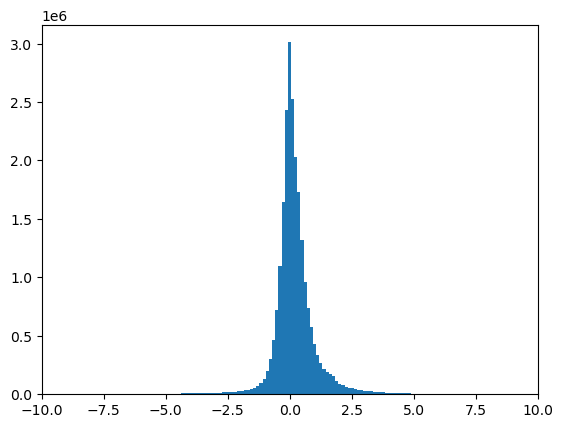

In [23]:
f, ax = plt.subplots()
ax.hist(diff.compressed(), bins=1024);
plt.xlim(-10, 10);

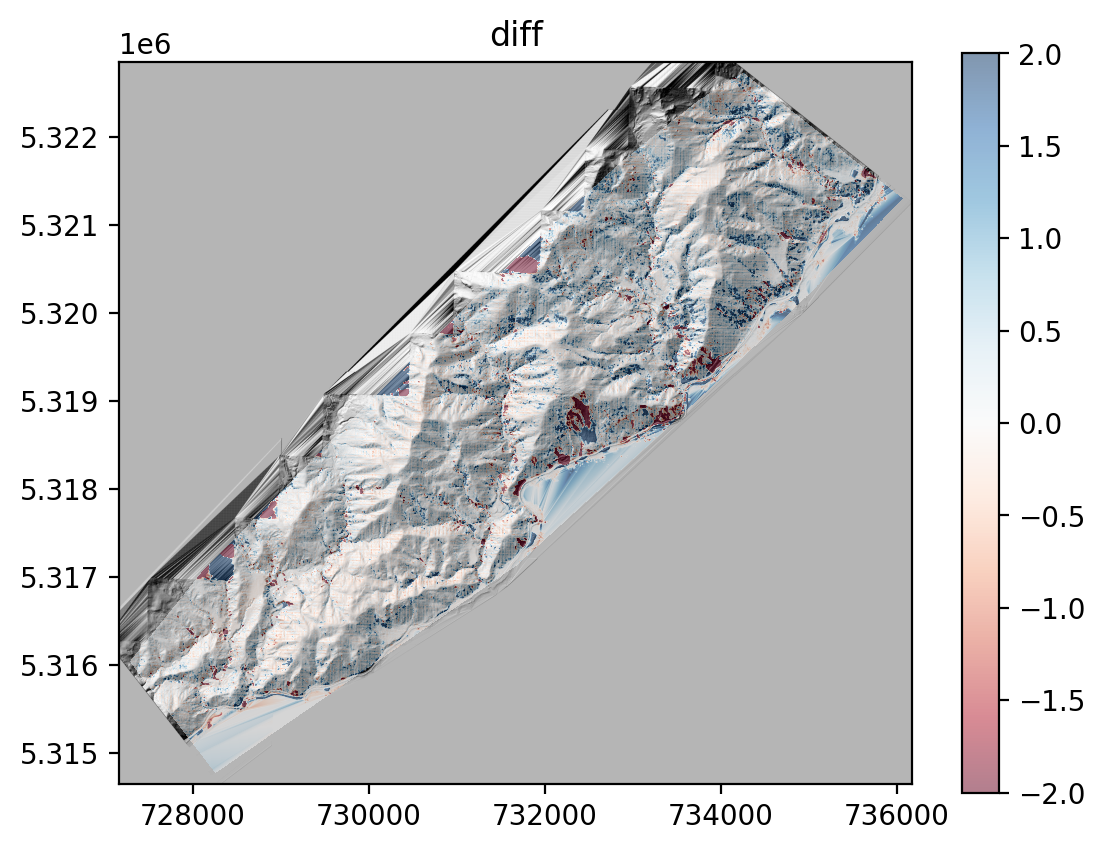

In [24]:
xmin, xmax, ymin, ymax = vrt18_fa_ma_extent

f, ax = plt.subplots(dpi=200)
# f, ax = plt.subplots()
ax.imshow(hs18_r, extent=hs18_r_extent, cmap='gray')
im = ax.imshow(diff, extent=vrt18_fa_ma_extent, vmin=-2, vmax=2, cmap='RdBu', alpha=0.5)
# inventory_gpd_clipped.plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_title('diff')
f.colorbar(im, ax=ax)
plt.xlim(xmin-100, xmax+100)
plt.ylim(ymin-100, ymax+100)
plt.show()

In [25]:
# fa_ma   = [vrt16_fa_ma, vrt17_fa_ma, vrt18_fa_ma]
# fa_vrts = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_fa.vrt",
#            "/home/jovyan/nz-landslides/1-raw-data/dem/2017_fa.vrt",
#            "/home/jovyan/nz-landslides/1-raw-data/dem/2018_fa.vrt"]
# affines = [vrt16_fa_transform, vrt17_fa_transform, vrt18_fa_transform]

# for ma, aff, path in zip(fa_ma, affines, fa_vrts):
#     create_vrt_from_masked_array(ma, path, aff, crs="EPSG:32759")